# 6-1. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# TensorFlow and tf.keras
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Helper libraries
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

#### Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?

CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

### Cutmix 함수

#### 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

#### 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수

In [5]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수

In [6]:
# mix two labels
# def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
#     image_size_x = image_a.shape[1]
#     image_size_y = image_a.shape[0] 
#     mixed_area = (x_max-x_min)*(y_max-y_min)
#     total_area = image_size_x*image_size_y
#     ratio = tf.cast(mixed_area/total_area, tf.float32)

#     if len(label_a.shape)==0:
#         label_a = tf.one_hot(label_a, num_classes)
#     if len(label_b.shape)==0:
#         label_b = tf.one_hot(label_b, num_classes)
#     mixed_label = (1-ratio)*label_a + ratio*label_b
#     return mixed_label

### 위 함수에서 image_a, image_b 를 참조 하지 못하는 에러 발생 하여 인자로 받을 수 있도록 아래와 같이 수정

In [7]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

#### mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수

In [8]:
# def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
#     mixed_imgs = []
#     mixed_labels = []

#     for i in range(batch_size):
#         image_a = image[i]
#         label_a = label[i]
#         j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
#         image_b = image[j]
#         label_b = label[j]
#         x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
#         mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
#         mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

#     mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
#     mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
#     return mixed_imgs, mixed_labels

### image_a, image_b 까지 전달 할 수 있도록 인자에 추가

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        # image_a, image_b 까지 전달 할 수 있도록 인자에 추가
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Mixup

#### 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨 섞기

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

#### 배치 단위의 mixup() 함수

In [11]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     if not is_test and with_aug:
#         ds = ds.map(
#             augment
#         )
#     ds = ds.batch(batch_size)
#     if not is_test and with_cutmix:
#         ds = ds.map(
#             cutmix,
#             num_parallel_calls=2
#         )
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

print('=3')

=3


In [13]:
# mixup 추가 하여 한번에 처리 가능 한 함수 구현
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes
print(num_classes)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

120


#### Cutmix 함수 테스트

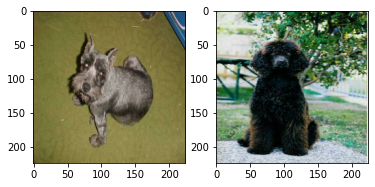

x :  tf.Tensor(3, shape=(), dtype=int32) tf.Tensor(157, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(183, shape=(), dtype=int32)


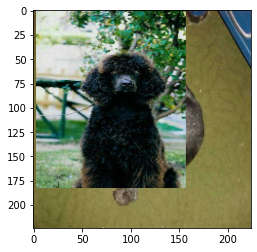

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.43833703, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.56166

In [15]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b)
mixed_label

#### Mixup 함수 테스트

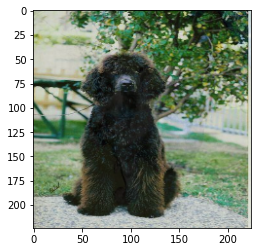

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17039335 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.82960665 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [16]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

### Cutmix 와 Mixup 데이터셋 만들기

In [17]:
ds_train_cutmix= apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

#### ResNet-50 직접 구현 코드 (tensorflow 에서 제공한 모델 사용 하여 주석 처리함)

In [18]:
# def basic_block(x, filters, stride=1, use_skip=True):
#     """기본 블록 - ResNet-34와 PlainNet-34에서 사용

#     인자:
#         x: 입력 텐서
#         filters: 합성곱 층의 필터 수
#         stride: 첫 번째 합성곱 층의 스트라이드 값
#         use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

#     반환:
#         블록의 출력 텐서
#     """
#     shortcut = x  # skip connection을 위해 입력 저장

#     # 첫 번째 합성곱 블록
#     x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 두 번째 합성곱 블록
#     x = layers.Conv2D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     if use_skip:  # ResNet의 경우에만 skip connection 적용
#         if stride != 1 or shortcut.shape[-1] != filters:
#             shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
#             shortcut = layers.BatchNormalization()(shortcut)
#         x = layers.Add()([shortcut, x])

#     x = layers.ReLU()(x)
#     return x

In [19]:
# def bottleneck_block(x, filters, stride=1, use_skip=True):
#     """병목 블록 - ResNet-50과 PlainNet-50에서 사용

#     인자:
#         x: 입력 텐서
#         filters: 주 합성곱 층의 필터 수
#         stride: 주 합성곱 층의 스트라이드 값
#         use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

#     반환:
#         블록의 출력 텐서
#     """
#     shortcut = x  # skip connection을 위해 입력 저장

#     # 첫 번째 1x1 합성곱 (차원 감소)
#     x = layers.Conv2D(filters, 1)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 3x3 합성곱
#     x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 마지막 1x1 합성곱 (차원 확장)
#     x = layers.Conv2D(filters * 4, 1)(x)
#     x = layers.BatchNormalization()(x)

#     if use_skip:  # ResNet의 경우에만 skip connection 적용
#         if stride != 1 or shortcut.shape[-1] != filters * 4:
#             shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
#             shortcut = layers.BatchNormalization()(shortcut)
#         x = layers.Add()([shortcut, x])

#     x = layers.ReLU()(x)
#     return x

In [20]:
# def build_network(is_50=False, use_skip=True):
#     """ResNet 또는 PlainNet 모델 생성

#     인자:
#         is_50: 50층 모델(True) 또는 34층 모델(False) 선택
#         use_skip: ResNet(True) 또는 PlainNet(False) 선택

#     반환:
#         구축된 모델
#     """
#     inputs = Input(shape=(224, 224, 3))
#     # 초기 합성곱 블록
#     x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#     # 모델 구성 설정
#     if is_50:
#         block_fn = bottleneck_block
#         filters = [64, 128, 256, 512]
#         blocks = [3, 4, 6, 3]
#     else:
#         block_fn = basic_block
#         filters = [64, 128, 256, 512]
#         blocks = [3, 4, 6, 3]

#     # 스테이지별 블록 생성
#     for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
#         for block_idx in range(block_count):
#             stride = 2 if block_idx == 0 and stage > 0 else 1
#             x = block_fn(x, filter_size, stride=stride, use_skip=use_skip)

#     # 최종 분류 층
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(10, activation='softmax')(x)

#     return Model(inputs, x)

In [21]:
# # 모델 생성 함수들
# def build_resnet(is_50=False):
#     """ResNet 모델 생성"""
#     return build_network(is_50=is_50, use_skip=True)

In [22]:
# def build_plainnet(is_50=False):
#     """PlainNet 모델 생성"""
#     return build_network(is_50=is_50, use_skip=False)

In [23]:
# resnet_50 = build_resnet(is_50=True)
# resnet_50.summary()

#### keras 모델 이용하기
- 함수로 만들어서 사용하도록 수정함

In [24]:
# 모델 생성 함수 정의
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=120):
    return tf.keras.models.Sequential([
        tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape,
            pooling='avg',
        ),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

In [25]:
# resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [26]:
# aug_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [27]:
# cutmix_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [28]:
# mixup_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

#### Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?

우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

### 이진 분류 모델을 위해 출력층 수정(softmax 추가) 및 컴파일
- CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [29]:
# EPOCH = 30 # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 50
learning_rate = 0.001

In [30]:
# Learning Rate 스케줄링 콜백 정의
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # 검증 손실 기준으로 학습률 조정
    factor=0.5,          # 학습률을 50%로 감소
    patience=5,          # 5 에포크 동안 개선되지 않으면 감소
    min_lr=1e-6,         # 학습률의 하한선 설정
    verbose=1            # 학습률 조정 시 메시지 출력
)

In [31]:
# 학습률 로깅 콜백 정의
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # lr = self.model.optimizer.learning_rate.numpy()
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1}: Learning rate is {lr}")

In [32]:
# 체크포인트 콜백 함수 정의
def create_checkpoint(filepath):
    return ModelCheckpoint(
        filepath=filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    )

In [33]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history.history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history.history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history.history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history.history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [34]:
# 모델 컴파일
def compile_model(model):
    model.compile(
        loss='categorical_crossentropy',
        # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy'],
    )
    return model

In [35]:
# 학습 실행
def train_resnet50(ds_train, ds_test, ds_info, EPOCH, model_name):
    model = create_resnet50_model(num_classes=ds_info.features['label'].num_classes)
    compile_model(model)

    resnet50_checkpoint = create_checkpoint(f"best_{model_name}_model_adam.h5")

    history = model.fit(
        ds_train, 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        callbacks=[resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
        use_multiprocessing=True,
    )
    return history

#### ResNet-50 직접 구현 코드 (tensorflow 에서 제공한 모델 사용 하여 주석 처리함)

In [36]:
# # softmax 미사용, SparseCategoricalCrossentropy(from_logits=True)
# def safety_modify_and_compile_model(model, num_classes, learning_rate=0.001):
#     outputs = tf.keras.layers.Dense(num_classes)(model.layers[-2].output)
#     model = tf.keras.Model(inputs=model.input, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy']
#     )
#     return model

In [37]:
# # softmax 사용, CategoricalCrossentropy
# def safety_modify_softmax_and_compile_model(model, num_classes, learning_rate=0.001):
#     outputs = layers.Dense(num_classes, activation='softmax')(model.layers[-2].output)
#     model = tf.keras.Model(inputs=model.input, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=['accuracy']
#     )
#     return model

In [38]:
# resnet_50 = safety_modify_and_compile_model(resnet_50, num_classes)
# resnet_50.summary()

In [39]:
# print("\nResNet-50 학습 중...")
# resnet50_history = resnet_50.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=EPOCH,
#     verbose=1,
#     # callbacks=callbacks
# )

### 'No Augmentation'

In [40]:
history_resnet50 = train_resnet50(ds_train_no_aug, ds_test, ds_info, 
                                         EPOCH, model_name="resnet50")

Epoch 1/50
750/750 [==============================] - 167s 205ms/step - loss: 4.6996 - accuracy: 0.0170 - val_loss: 5.1641 - val_accuracy: 0.0096

Epoch 00001: val_loss improved from inf to 5.16411, saving model to best_resnet50_model_adam.h5
Epoch 1: Learning rate is 0.0010000000474974513
Epoch 2/50
750/750 [==============================] - 154s 205ms/step - loss: 4.3651 - accuracy: 0.0394 - val_loss: 4.3944 - val_accuracy: 0.0419

Epoch 00002: val_loss improved from 5.16411 to 4.39443, saving model to best_resnet50_model_adam.h5
Epoch 2: Learning rate is 0.0010000000474974513
Epoch 3/50
750/750 [==============================] - 154s 205ms/step - loss: 3.9693 - accuracy: 0.0750 - val_loss: 4.4762 - val_accuracy: 0.0498

Epoch 00003: val_loss did not improve from 4.39443
Epoch 3: Learning rate is 0.0010000000474974513
Epoch 4/50
750/750 [==============================] - 154s 205ms/step - loss: 3.5705 - accuracy: 0.1211 - val_loss: 4.2015 - val_accuracy: 0.0862

Epoch 00004: val_loss

750/750 [==============================] - 154s 205ms/step - loss: 7.2740e-04 - accuracy: 0.9999 - val_loss: 4.5669 - val_accuracy: 0.3469

Epoch 00032: val_loss did not improve from 3.28602
Epoch 32: Learning rate is 6.25000029685907e-05
Epoch 33/50
750/750 [==============================] - 154s 205ms/step - loss: 5.2594e-04 - accuracy: 1.0000 - val_loss: 4.5887 - val_accuracy: 0.3531

Epoch 00033: val_loss did not improve from 3.28602
Epoch 33: Learning rate is 6.25000029685907e-05
Epoch 34/50
750/750 [==============================] - 154s 205ms/step - loss: 9.2656e-04 - accuracy: 0.9998 - val_loss: 4.6571 - val_accuracy: 0.3510

Epoch 00034: val_loss did not improve from 3.28602

Epoch 00034: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 34: Learning rate is 3.125000148429535e-05
Epoch 35/50
750/750 [==============================] - 154s 205ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 4.6381 - val_accuracy: 0.3504

Epoch 00035: val_loss did not

In [41]:
# # 체크포인트 콜백 정의
# resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [42]:
# resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_resnet50 = resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

resnet50


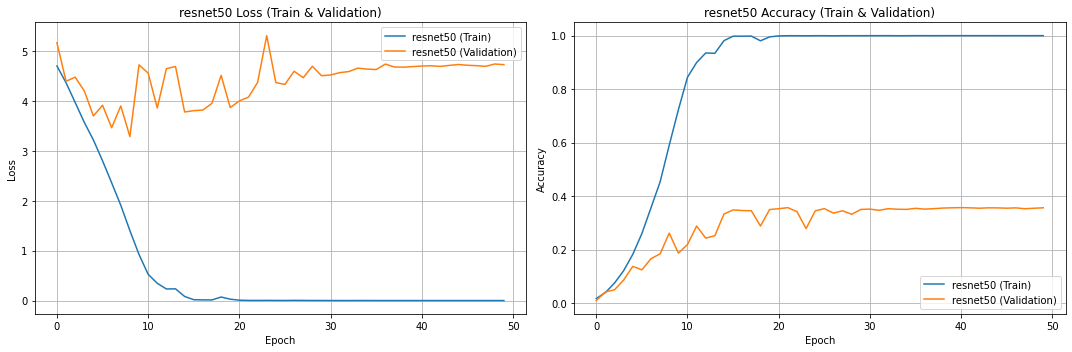

In [43]:
print("resnet50")
plot_metrics(history_resnet50, 'resnet50')

### 'With Augmentation'

In [44]:
history_aug_resnet50 = train_resnet50(ds_train_aug, ds_test, ds_info, 
                                      EPOCH, model_name="aug_resnet50")

Epoch 1/50
  6/750 [..............................] - ETA: 2:05 - loss: 5.7160 - accuracy: 0.0104WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0783s vs `on_train_batch_end` time: 0.0967s). Check your callbacks.


750/750 [==============================] - 162s 206ms/step - loss: 4.8152 - accuracy: 0.0111 - val_loss: 5.4477 - val_accuracy: 0.0059

Epoch 00001: val_loss improved from inf to 5.44772, saving model to best_aug_resnet50_model_adam.h5
Epoch 1: Learning rate is 0.0010000000474974513
Epoch 2/50
750/750 [==============================] - 154s 205ms/step - loss: 4.6568 - accuracy: 0.0176 - val_loss: 4.6979 - val_accuracy: 0.0149

Epoch 00002: val_loss improved from 5.44772 to 4.69786, saving model to best_aug_resnet50_model_adam.h5
Epoch 2: Learning rate is 0.0010000000474974513
Epoch 3/50
750/750 [==============================] - 154s 205ms/step - loss: 4.4813 - accuracy: 0.0297 - val_loss: 5.0115 - val_accuracy: 0.0155

Epoch 00003: val_loss did not improve from 4.69786
Epoch 3: Learning rate is 0.0010000000474974513
Epoch 4/50
750/750 [==============================] - 154s 205ms/step - loss: 4.2198 - accuracy: 0.0468 - val_loss: 4.8005 - val_accuracy: 0.0457

Epoch 00004: val_loss di


Epoch 00032: val_loss did not improve from 2.99466
Epoch 32: Learning rate is 0.0001250000059371814
Epoch 33/50
750/750 [==============================] - 154s 205ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 4.0484 - val_accuracy: 0.3781

Epoch 00033: val_loss did not improve from 2.99466
Epoch 33: Learning rate is 0.0001250000059371814
Epoch 34/50
750/750 [==============================] - 154s 206ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 3.8397 - val_accuracy: 0.3991

Epoch 00034: val_loss did not improve from 2.99466
Epoch 34: Learning rate is 0.0001250000059371814
Epoch 35/50
750/750 [==============================] - 154s 205ms/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 3.9865 - val_accuracy: 0.3910

Epoch 00035: val_loss did not improve from 2.99466

Epoch 00035: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 35: Learning rate is 6.25000029685907e-05
Epoch 36/50
750/750 [==============================] - 154s 205ms/step - los

In [45]:
# # 체크포인트 콜백 정의
# aug_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_aug_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [46]:
# aug_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_aug_resnet50 = aug_resnet50.fit(
#     ds_train_aug, # augmentation 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[aug_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

aug_resnet50


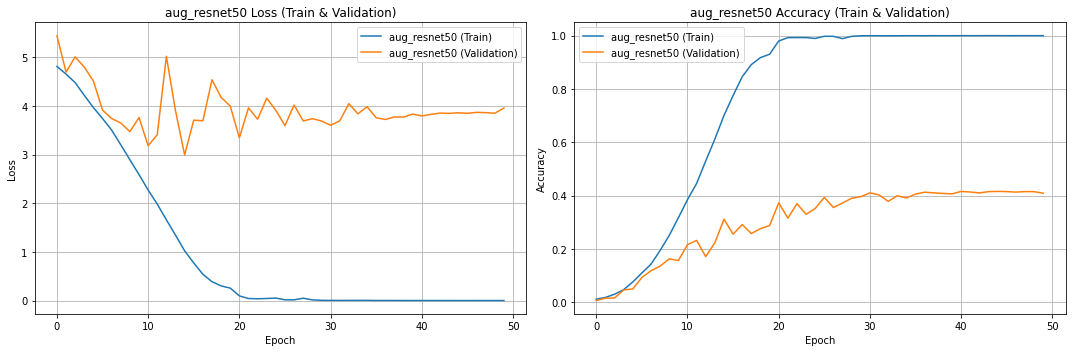

In [47]:
print("aug_resnet50")
plot_metrics(history_aug_resnet50, 'aug_resnet50')

### 'Augmentation + Cutmix'

In [48]:
history_cutmix_resnet50 = train_resnet50(ds_train_cutmix, ds_test, ds_info, 
                                         EPOCH, model_name="cutmix_resnet50")

Epoch 1/50
  6/750 [..............................] - ETA: 2:07 - loss: 5.6401 - accuracy: 0.0417WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0545s vs `on_train_batch_end` time: 0.1183s). Check your callbacks.


750/750 [==============================] - 165s 208ms/step - loss: 4.8159 - accuracy: 0.0111 - val_loss: 4.8472 - val_accuracy: 0.0087

Epoch 00001: val_loss improved from inf to 4.84722, saving model to best_cutmix_resnet50_model_adam.h5
Epoch 1: Learning rate is 0.0010000000474974513
Epoch 2/50
750/750 [==============================] - 156s 207ms/step - loss: 4.7100 - accuracy: 0.0174 - val_loss: 4.7640 - val_accuracy: 0.0162

Epoch 00002: val_loss improved from 4.84722 to 4.76396, saving model to best_cutmix_resnet50_model_adam.h5
Epoch 2: Learning rate is 0.0010000000474974513
Epoch 3/50
750/750 [==============================] - 155s 207ms/step - loss: 4.6318 - accuracy: 0.0244 - val_loss: 6.2839 - val_accuracy: 0.0180

Epoch 00003: val_loss did not improve from 4.76396
Epoch 3: Learning rate is 0.0010000000474974513
Epoch 4/50
750/750 [==============================] - 156s 208ms/step - loss: 4.5455 - accuracy: 0.0338 - val_loss: 6.1367 - val_accuracy: 0.0258

Epoch 00004: val_l

750/750 [==============================] - 160s 214ms/step - loss: 2.1292 - accuracy: 0.6754 - val_loss: 2.2538 - val_accuracy: 0.4339

Epoch 00031: val_loss did not improve from 2.22633
Epoch 31: Learning rate is 0.0001250000059371814
Epoch 32/50
750/750 [==============================] - 161s 215ms/step - loss: 2.0555 - accuracy: 0.7012 - val_loss: 2.3191 - val_accuracy: 0.4205

Epoch 00032: val_loss did not improve from 2.22633
Epoch 32: Learning rate is 0.0001250000059371814
Epoch 33/50
750/750 [==============================] - 162s 216ms/step - loss: 2.0271 - accuracy: 0.7070 - val_loss: 2.2668 - val_accuracy: 0.4334

Epoch 00033: val_loss did not improve from 2.22633
Epoch 33: Learning rate is 0.0001250000059371814
Epoch 34/50
750/750 [==============================] - 162s 216ms/step - loss: 1.9904 - accuracy: 0.7248 - val_loss: 2.2817 - val_accuracy: 0.4293

Epoch 00034: val_loss did not improve from 2.22633
Epoch 34: Learning rate is 0.0001250000059371814
Epoch 35/50
750/750 

In [49]:
# # 체크포인트 콜백 정의
# cutmix_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_cutmix_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [50]:
# cutmix_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_cutmix_resnet50 = cutmix_resnet50.fit(
#     ds_train_cutmix, # CutMix 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[cutmix_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

cutmix_resnet50


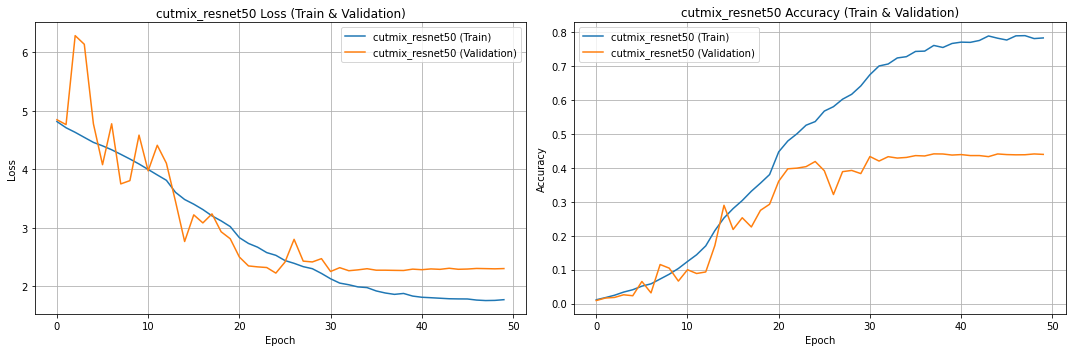

In [51]:
print("cutmix_resnet50")
plot_metrics(history_cutmix_resnet50, 'cutmix_resnet50')

### 'Augmentation + Mixup'

In [52]:
history_mixup_resnet50 = train_resnet50(ds_train_mixup, ds_test, ds_info, 
                                        EPOCH, model_name="mixup_resnet50")

Epoch 1/50
  6/750 [..............................] - ETA: 2:09 - loss: 5.3780 - accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0597s vs `on_train_batch_end` time: 0.1188s). Check your callbacks.


750/750 [==============================] - 156s 207ms/step - loss: 4.7182 - accuracy: 0.0178 - val_loss: 5.0115 - val_accuracy: 0.0149

Epoch 00002: val_loss did not improve from 4.96386
Epoch 2: Learning rate is 0.0010000000474974513
Epoch 3/50
750/750 [==============================] - 155s 207ms/step - loss: 4.6138 - accuracy: 0.0278 - val_loss: 6.8561 - val_accuracy: 0.0089

Epoch 00003: val_loss did not improve from 4.96386
Epoch 3: Learning rate is 0.0010000000474974513
Epoch 4/50
750/750 [==============================] - 155s 207ms/step - loss: 4.5224 - accuracy: 0.0339 - val_loss: 4.7732 - val_accuracy: 0.0205

Epoch 00004: val_loss improved from 4.96386 to 4.77323, saving model to best_mixup_resnet50_model_adam.h5
Epoch 4: Learning rate is 0.0010000000474974513
Epoch 5/50
750/750 [==============================] - 156s 208ms/step - loss: 4.4493 - accuracy: 0.0428 - val_loss: 4.5627 - val_accuracy: 0.0244

Epoch 00005: val_loss improved from 4.77323 to 4.56272, saving model to

750/750 [==============================] - 161s 215ms/step - loss: 2.0343 - accuracy: 0.7804 - val_loss: 2.8496 - val_accuracy: 0.3258

Epoch 00032: val_loss did not improve from 2.75038

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 32: Learning rate is 0.0005000000237487257
Epoch 33/50
750/750 [==============================] - 162s 215ms/step - loss: 1.8973 - accuracy: 0.8313 - val_loss: 2.5542 - val_accuracy: 0.3849

Epoch 00033: val_loss improved from 2.75038 to 2.55423, saving model to best_mixup_resnet50_model_adam.h5
Epoch 33: Learning rate is 0.0005000000237487257
Epoch 34/50
750/750 [==============================] - 156s 208ms/step - loss: 1.8105 - accuracy: 0.8491 - val_loss: 2.6875 - val_accuracy: 0.3616

Epoch 00034: val_loss did not improve from 2.55423
Epoch 34: Learning rate is 0.0005000000237487257
Epoch 35/50
750/750 [==============================] - 159s 212ms/step - loss: 1.8002 - accuracy: 0.8503 - val_loss: 2.6455 - val_ac

In [53]:
# # 체크포인트 콜백 정의
# mixup_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_mixup_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [54]:
# mixup_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_mixup_resnet50 = mixup_resnet50.fit(
#     ds_train_mixup, # Mixup 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[mixup_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

mixup_resnet50


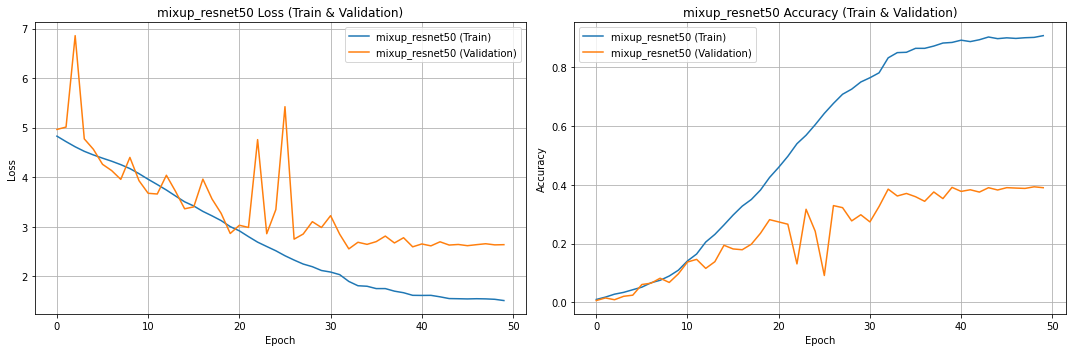

In [55]:
print("mixup_resnet50")
plot_metrics(history_mixup_resnet50, 'mixup_resnet50')

### 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

In [56]:
import matplotlib.pyplot as plt

def plot_comparison(history_dict, title="Validation Metrics for Different Techniques"):
    """
    여러 학습 이력에 대한 검증 손실과 정확도를 하나의 그림에 시각화합니다.

    매개변수:
    history_dict: 딕셔너리로, 키는 기법 이름이고 값은 Keras History 객체입니다.
    title: 플롯의 제목.
    """
    plt.figure(figsize=(12, 16))

    # 검증 손실 플롯
    plt.subplot(2, 1, 1)
    for label, history in history_dict.items():
        plt.plot(history.history['val_loss'], label=f'{label} Loss')
    plt.title('Validation Loss')  # 제목: 검증 손실
    plt.xlabel('Epoch')  # x축 레이블: Epoch
    plt.ylabel('Loss')  # y축 레이블: Loss
    plt.legend()  # 범례 추가

    # 검증 정확도 플롯
    plt.subplot(2, 1, 2)
    for label, history in history_dict.items():
        plt.plot(history.history['val_accuracy'], label=f'{label} Accuracy')
    plt.title('Validation Accuracy')  # 제목: 검증 정확도
    plt.xlabel('Epoch')  # x축 레이블: Epoch
    plt.ylabel('Accuracy')  # y축 레이블: Accuracy
    plt.legend()  # 범례 추가

    plt.suptitle(title)  # 전체 제목 설정
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

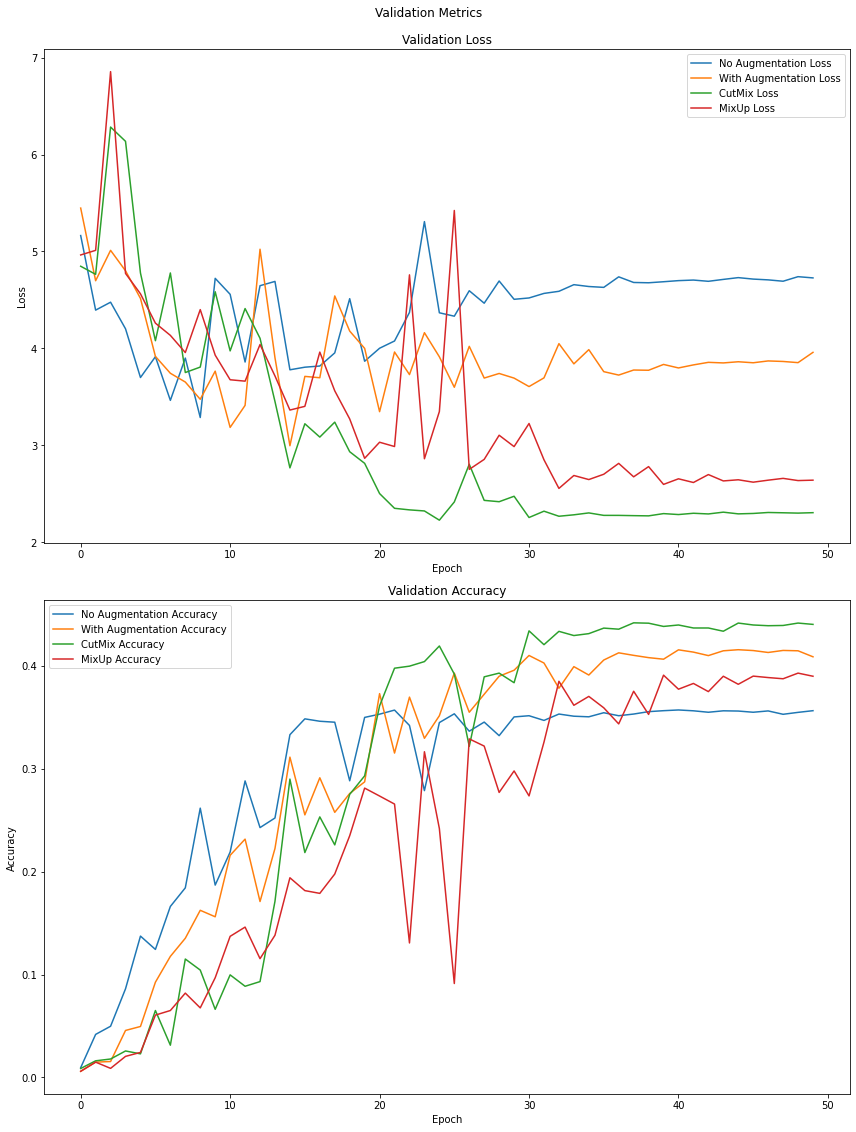

In [57]:
history_dict = {
    "No Augmentation": history_resnet50,
    "With Augmentation": history_aug_resnet50,
    "CutMix": history_cutmix_resnet50,
    "MixUp": history_mixup_resnet50
}
plot_comparison(history_dict, title="Validation Metrics\n")

### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [58]:
def create_comparison_tables(history_resnet50, history_aug_resnet50,
                           history_cutmix_resnet50, history_mixup_resnet50):

    # 각 모델의 최고 validation accuracy
    accuracies = {
        'resnet50_no_aug': max(history_resnet50.history['val_accuracy']) * 100,
        'resnet50_aug': max(history_aug_resnet50.history['val_accuracy']) * 100,
        'resnet50_cutMix': max(history_cutmix_resnet50.history['val_accuracy']) * 100,
        'resnet50_mixup': max(history_mixup_resnet50.history['val_accuracy']) * 100
    }

    # 1. resnet50_no_aug vs resnet50_aug
    print("\nresnet50_no_aug vs resnet50_aug - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_no_aug':<15} {accuracies['resnet50_no_aug']:>15.2f}")
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print("-" * 40)

    # 2. resnet50_aug vs resnet50_cutMix
    print("\nresnet50_aug vs resnet50_cutMix - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print(f"{'resnet50_cutMix':<15} {accuracies['resnet50_cutMix']:>15.2f}")
    print("-" * 40)

    # 3. resnet50_aug vs resnet50_mixup
    print("\nresnet50_aug vs resnet50_mixup - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print(f"{'resnet50_mixup':<15} {accuracies['resnet50_mixup']:>15.2f}")
    print("-" * 40)
    
    # 4. resnet50_cutMix vs resnet50_mixup
    print("\nresnet50_cutMix vs resnet50_mixup - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_cutMix':<15} {accuracies['resnet50_cutMix']:>15.2f}")
    print(f"{'resnet50_mixup':<15} {accuracies['resnet50_mixup']:>15.2f}")
    print("-" * 40)

In [59]:
# 결과표 생성
create_comparison_tables(history_resnet50, history_aug_resnet50,
                           history_cutmix_resnet50, history_mixup_resnet50)


resnet50_no_aug vs resnet50_aug - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_no_aug           35.70
resnet50_aug              41.56
----------------------------------------

resnet50_aug vs resnet50_cutMix - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_aug              41.56
resnet50_cutMix           44.17
----------------------------------------

resnet50_aug vs resnet50_mixup - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_aug              41.56
resnet50_mixup            39.28
----------------------------------------

resnet50_cutMix vs resnet50_mixup - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
---------------------------------

### 첫 번째 실험
- EPOCH = 30
- SGD
- learning_rate = 0.01

### 두 번째 실험
- lr_scheduler, LearningRateLogger 추가
- EPOCH = 50 변경
- Adam 변경
- 초기 learning_rate=0.05 로 설정

### 세 번째 실험
- 초기 learning_rate=0.01 로 설정
- Code-Refactoring(모델생성, 컴파일, train 로직 함수화)

### 네 번째 실험
- optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

### 다섯번째 실험
- EPOCH = 40 으로 변경
- learning_rate = 0.05로 변경

### 여섯번째 실험
- EPOCH = 50 로 변경
- learning_rate = 0.005 로 변경

### 일곱번째 실험
- Adam 변경
- learning_rate = 0.001 로 변경

### 첫번째 실험 epoch = 30 에서 결과
- resnet50_aug Accuracy가 가장 높게 나왔다.
- 주목할 건 resnet50_cutMix 와 resnet50_mixup Accuracy 가 resnet50_no_aug 보다 낮게 나왔다.
- cutMix 와 mixup 의 validation loss 가 더 빨리 떨어지면서 train loss 보다 더 낮다. 아직 학습이 덜 된건가?
- cutMix 와 mixup 의 validation accuracy 의 최고점을 찾아가는 epoch 수 자체는 빨리 도달 했다.
- 2차 실험 진행 해본다. 

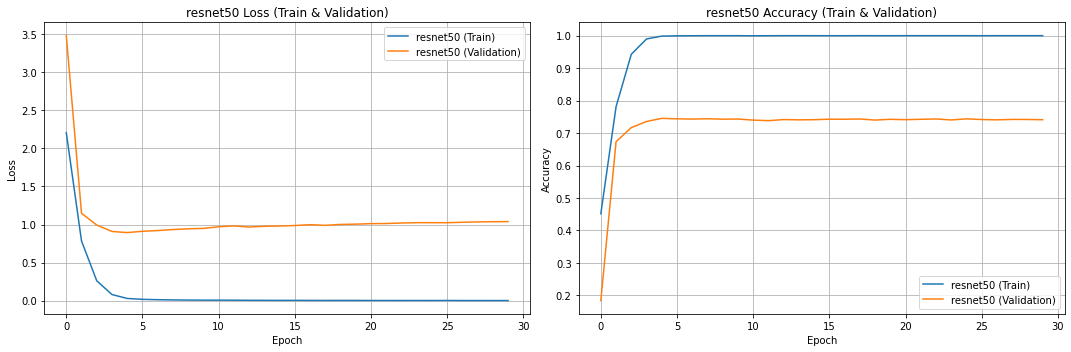  
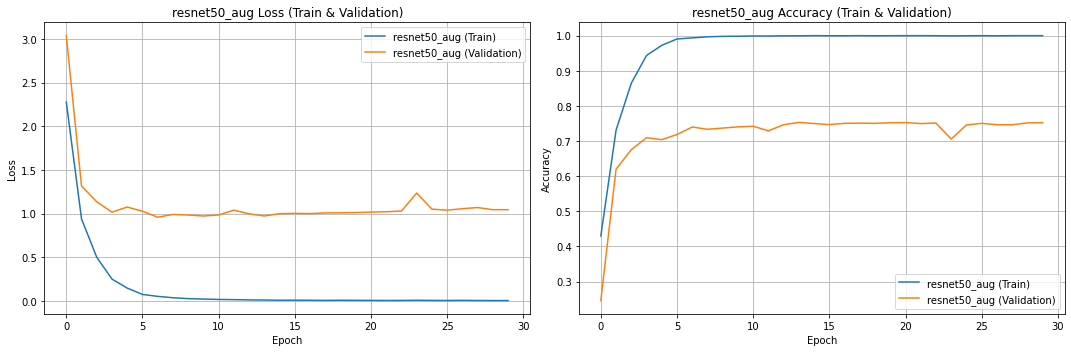  
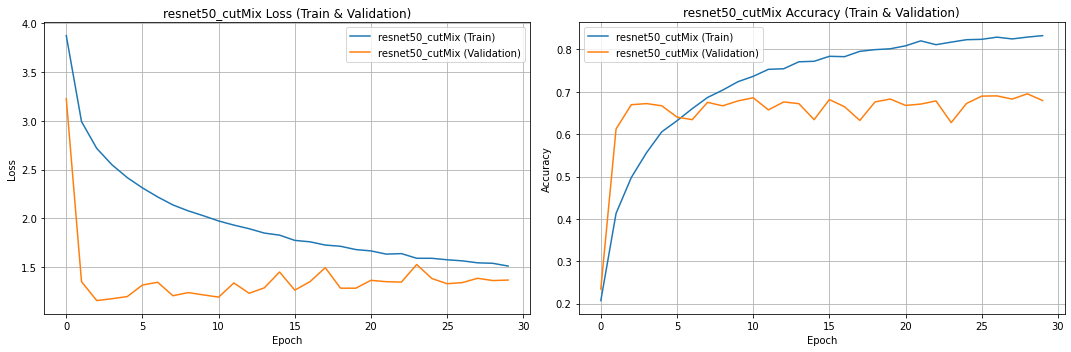  
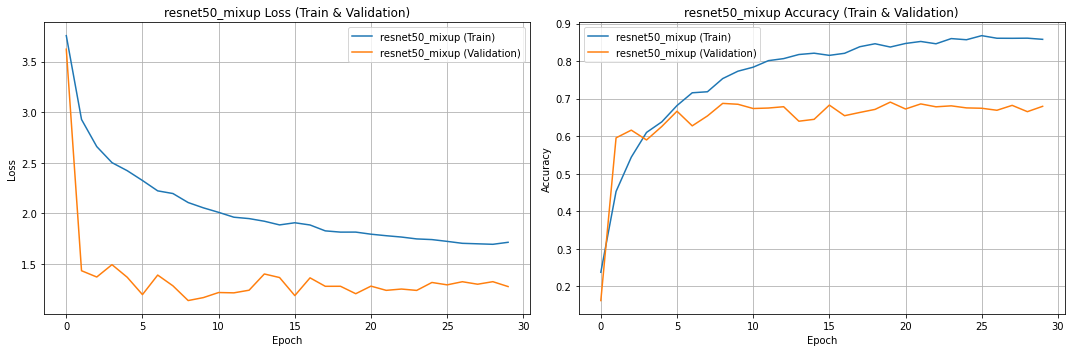
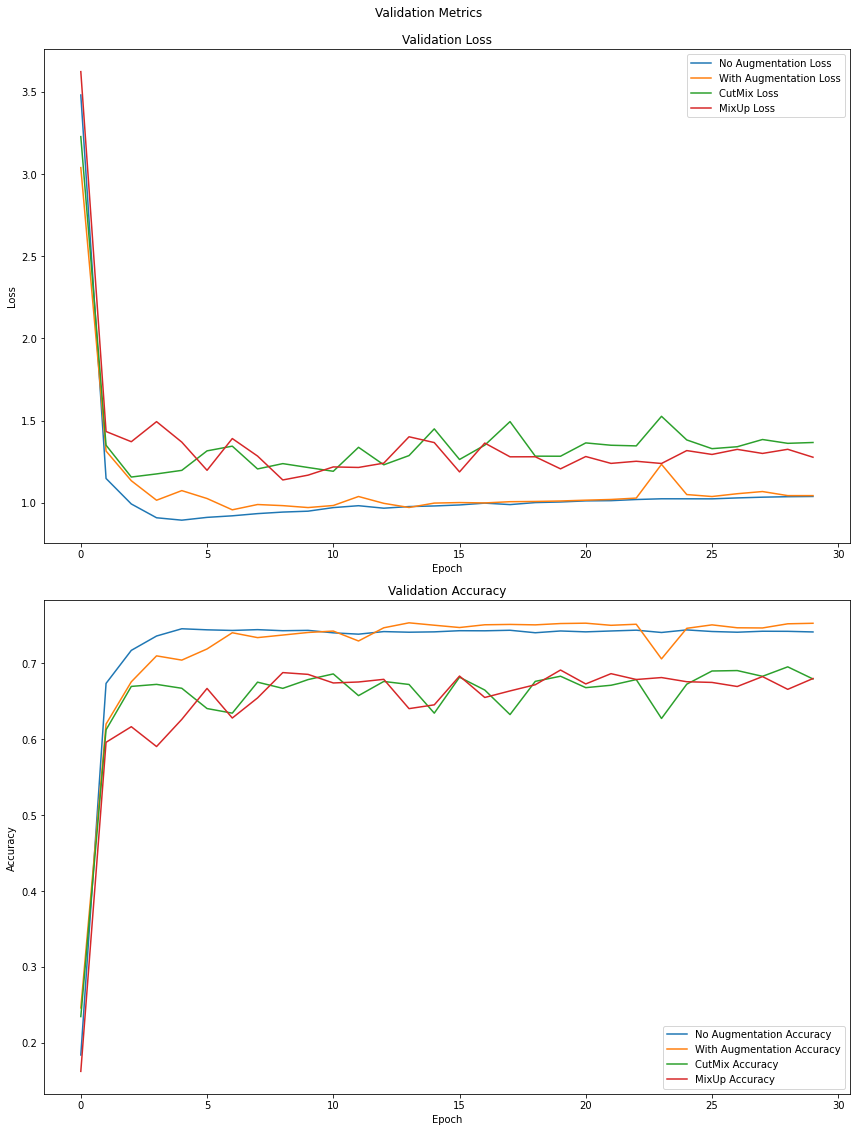
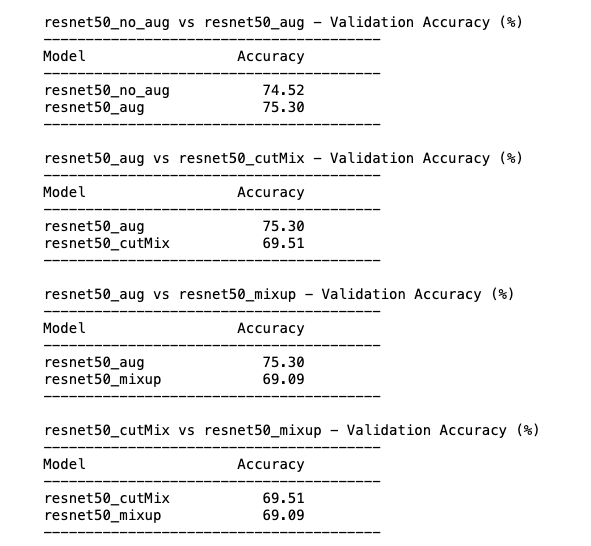

### 두번째 실험
- 학습이 전현 안되었다.
- lr 설정이 초반에 너무 크게 잡은거 같은데 다시 수정해서 3차 실험 해본다.

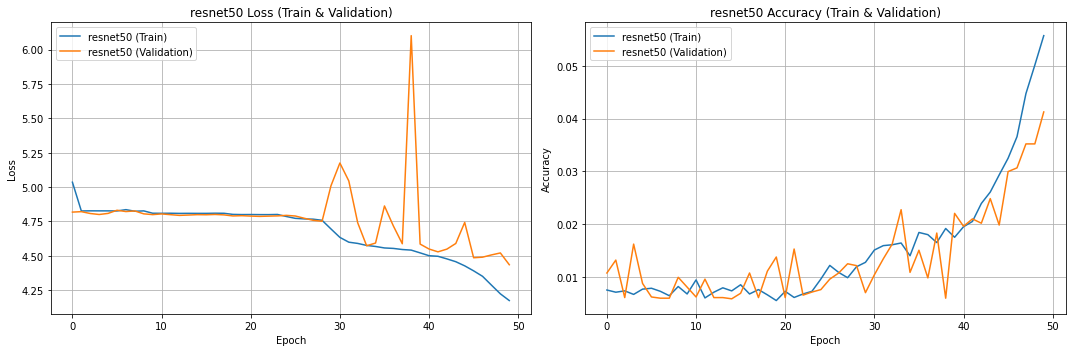
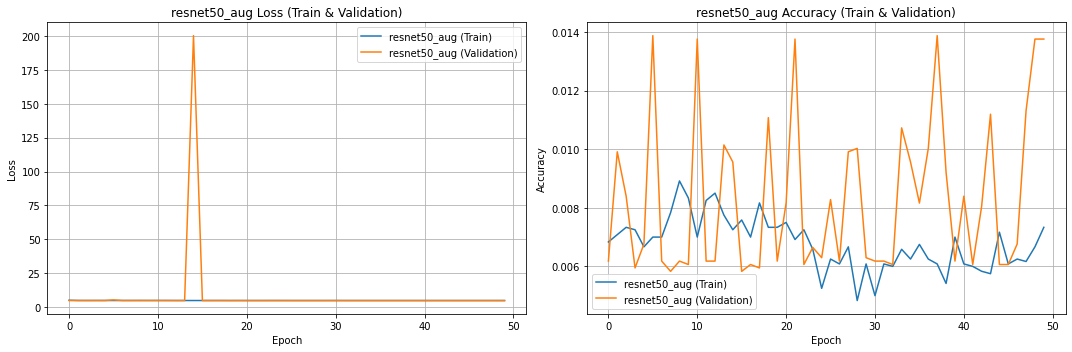
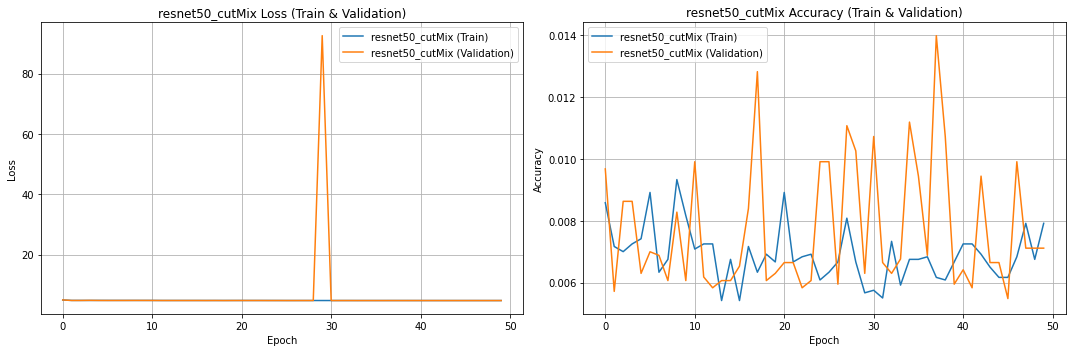
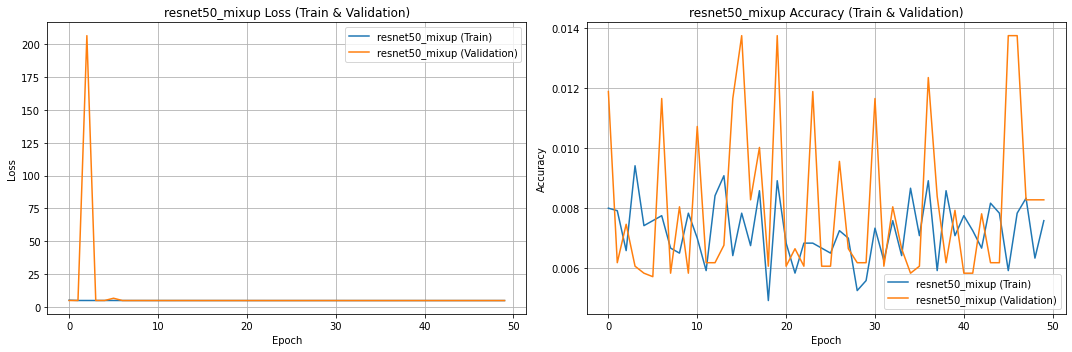
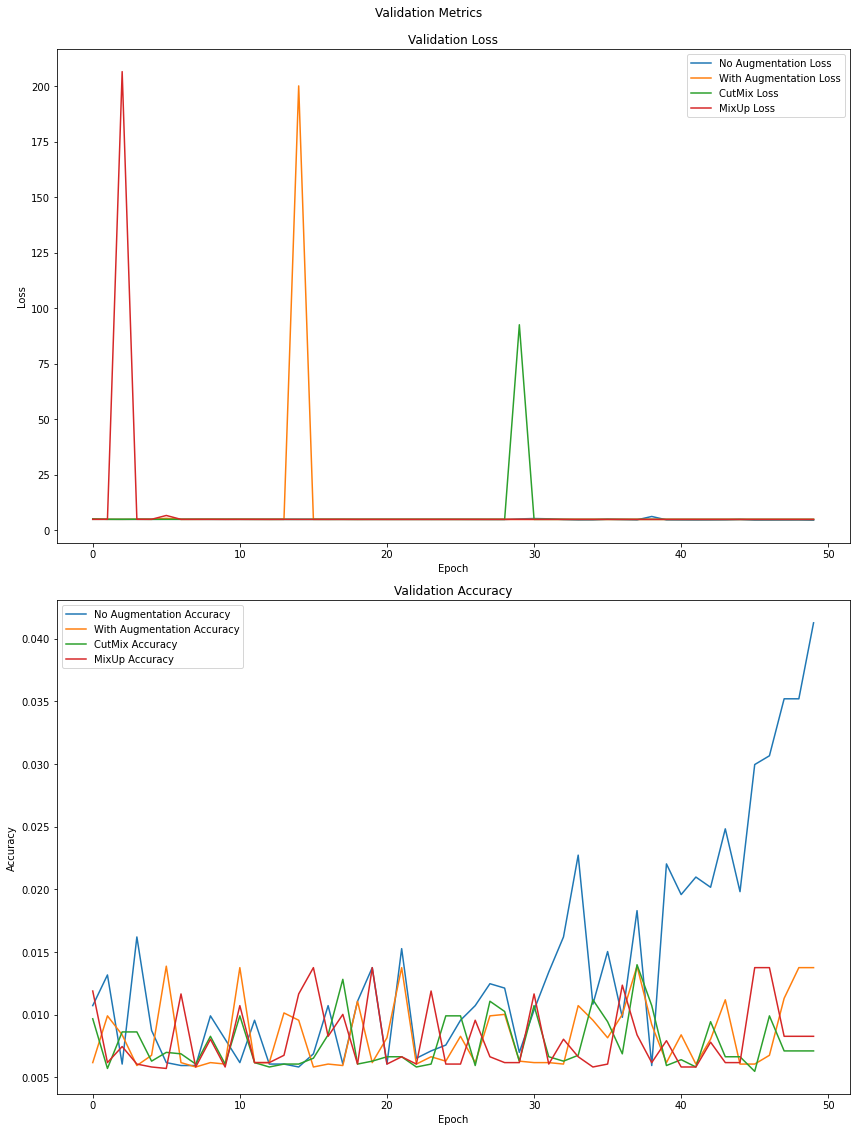
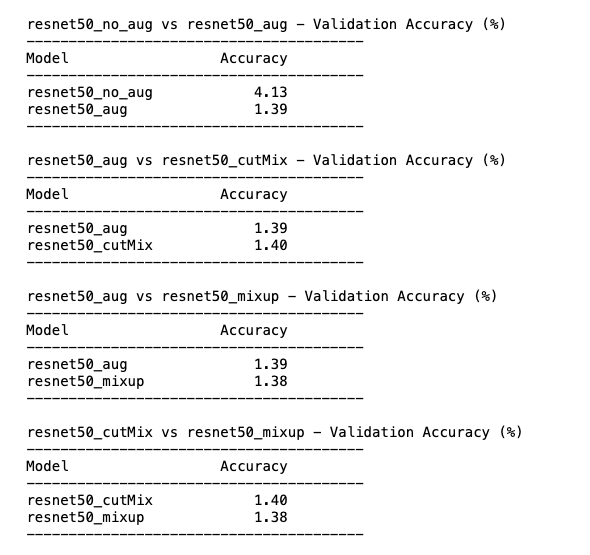

### 세번째 실험
- Adam 이 SGD 보다 성능이 안나오고 있다. 
- 실험을 중단하고 다시 SGD(momentum=0.9 적용)로 변경 후 실험 진행(나머지는 2번째와 동일하게 유지)

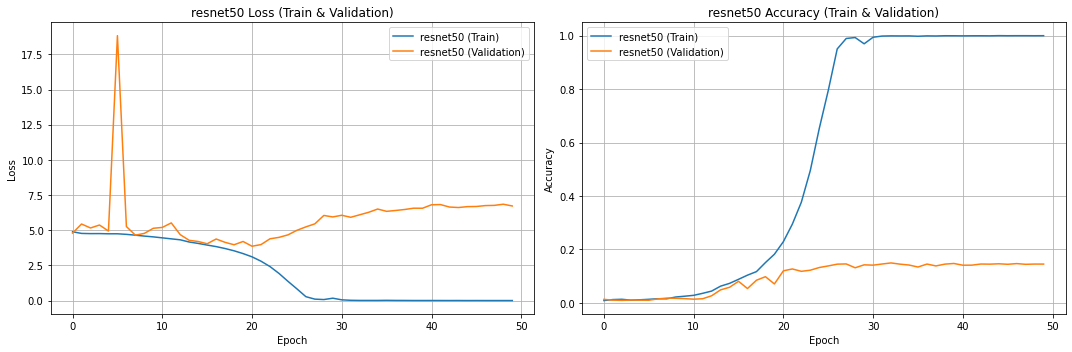

### 네번째 실험
- **history_mixup_resnet50 에서 epoch 50 까지 훈련은 되었으나 멈춰버림**
- 이번에는 cutMix 와 mixup 이 근소하게 validation 성능이 높게 나왔음

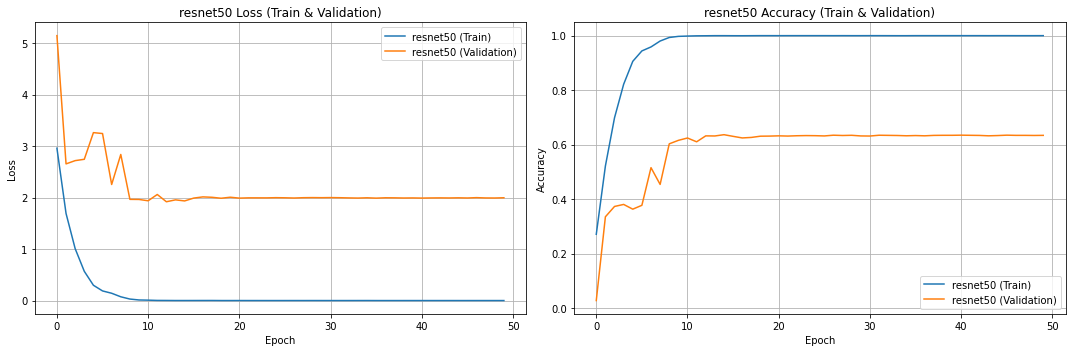
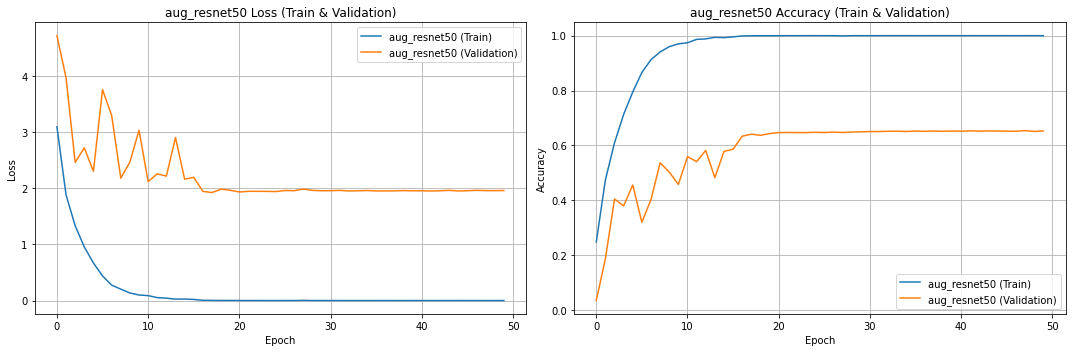
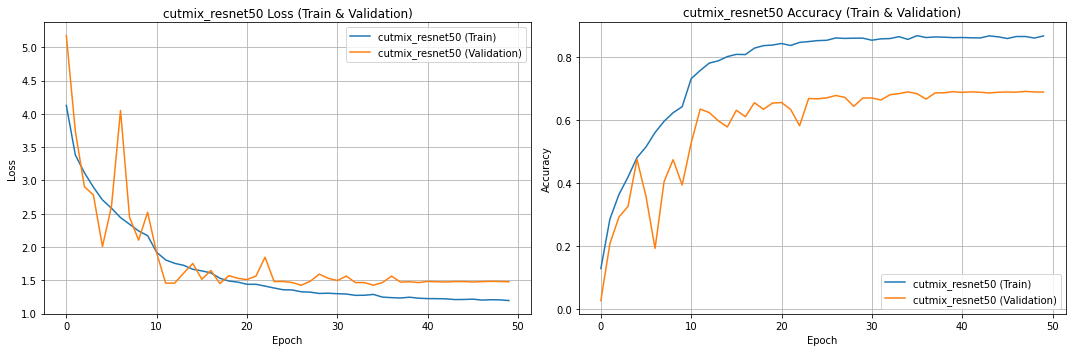  
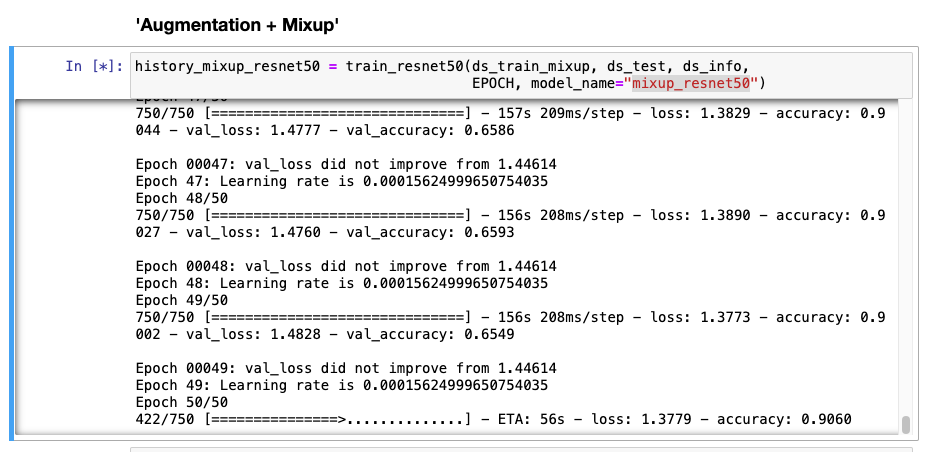
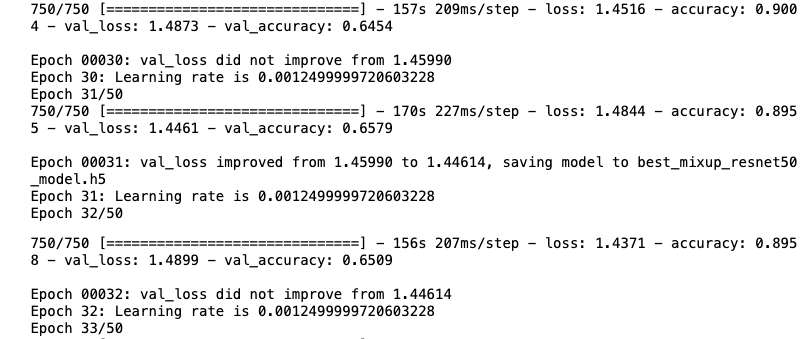

### 다섯번째 실험
- 초기 learning_rate = 0.05 에서 epoch=40 은 cutmix 나 mixup 의 경우 학습이 더 필요해 보인다.
- 0.01 보다 학습도 느리고 결과도 좋지 않다.
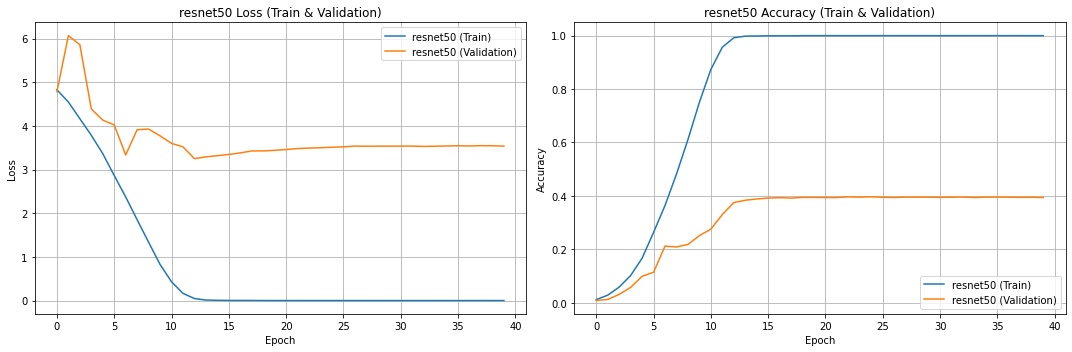
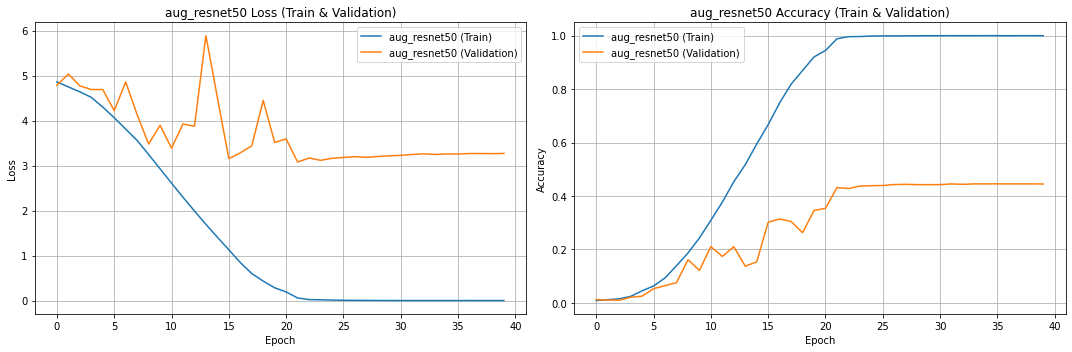
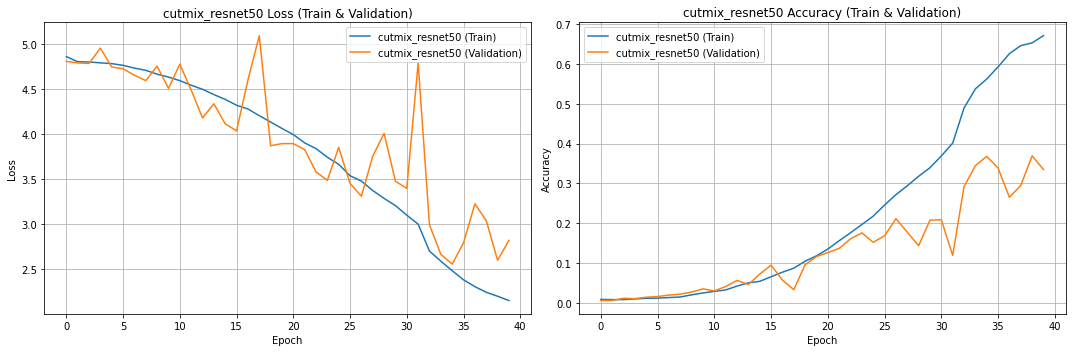
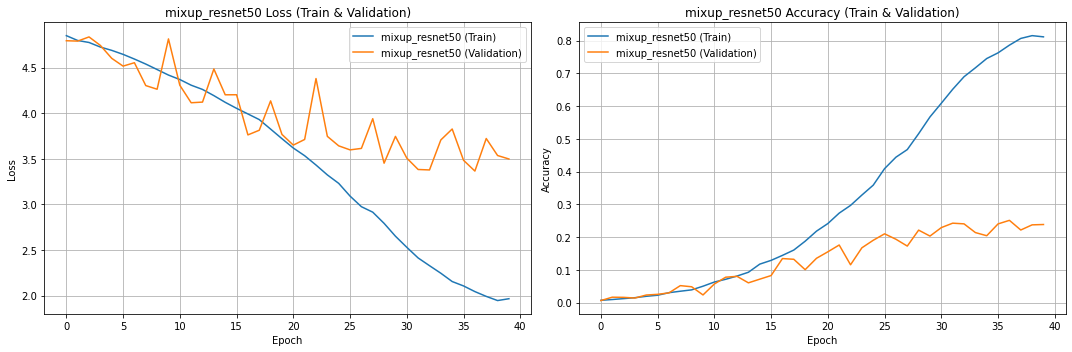
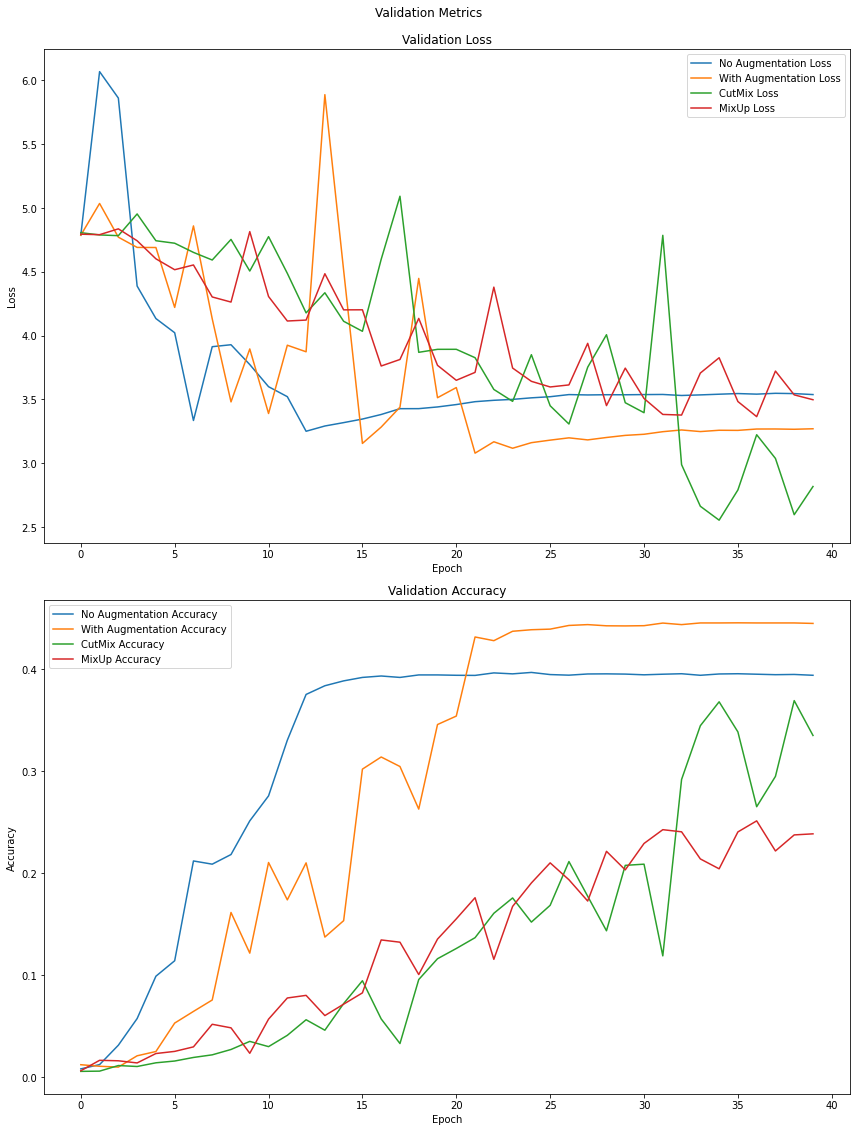
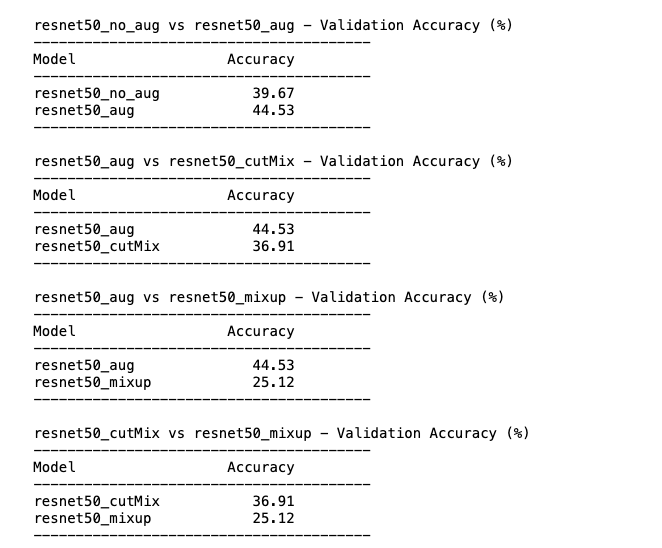

### 여섯번째 실험
- 학습 속도는 resnet50_no_aug, resnet50_aug, resnet50_cutmix, resnet50_mixup 순서대로 최적값을 찾아갔으나
- 40 epoch 이후로는 4가지 성능이 거의 비슷하게 수렴했다.
- resnet50_no_aug, resnet50_aug 은 train 과 validation loss 의 차이가 비교적 큰 반면
- resnet50_cutmix, resnet50_mixup 은 차이가 거의 없다.

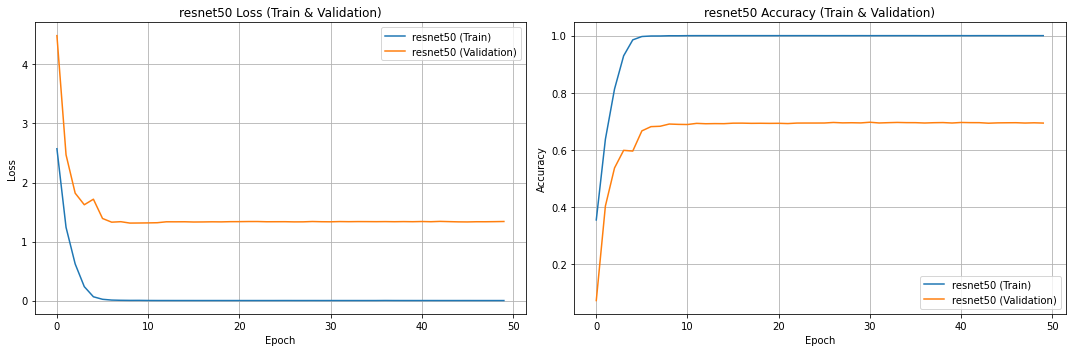
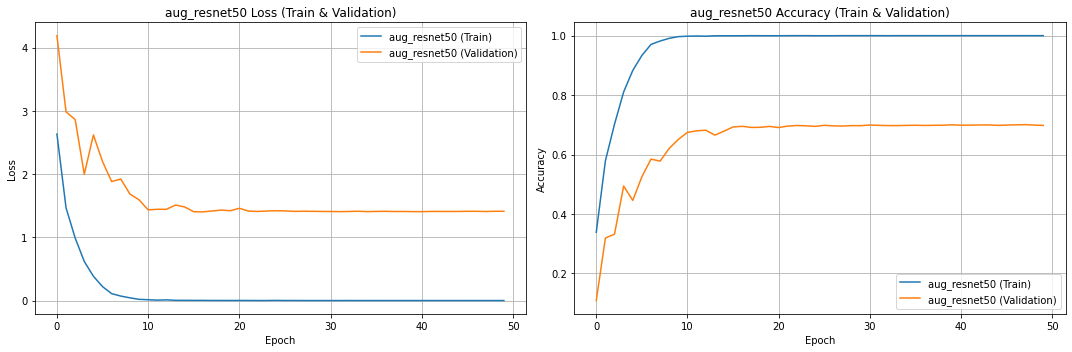
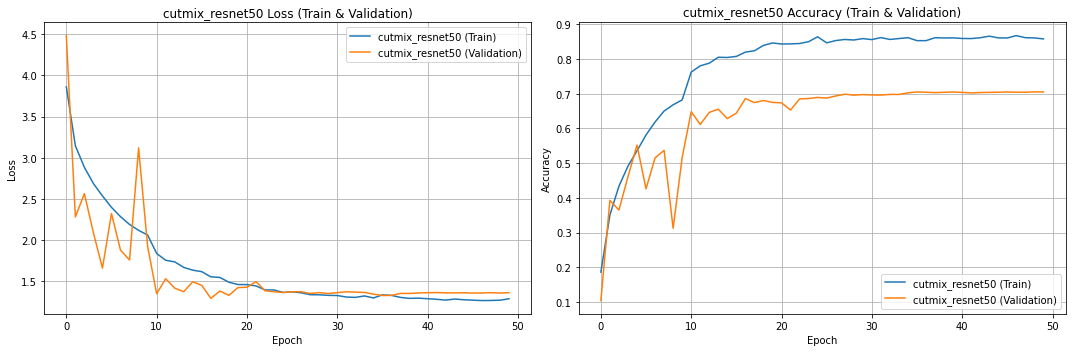
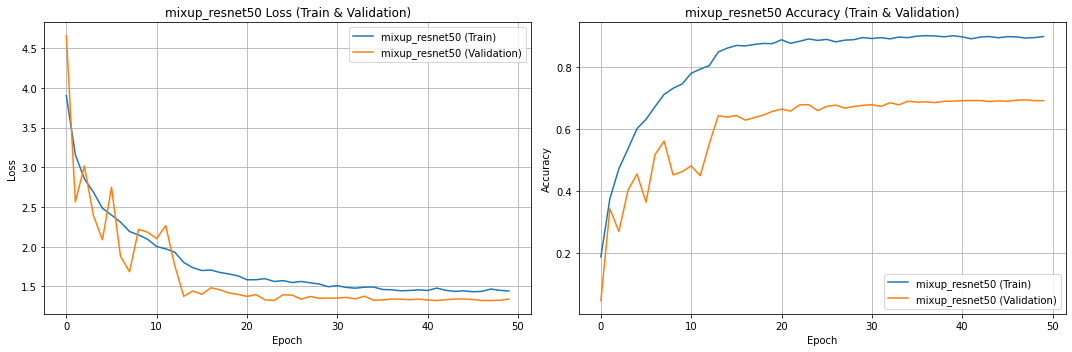
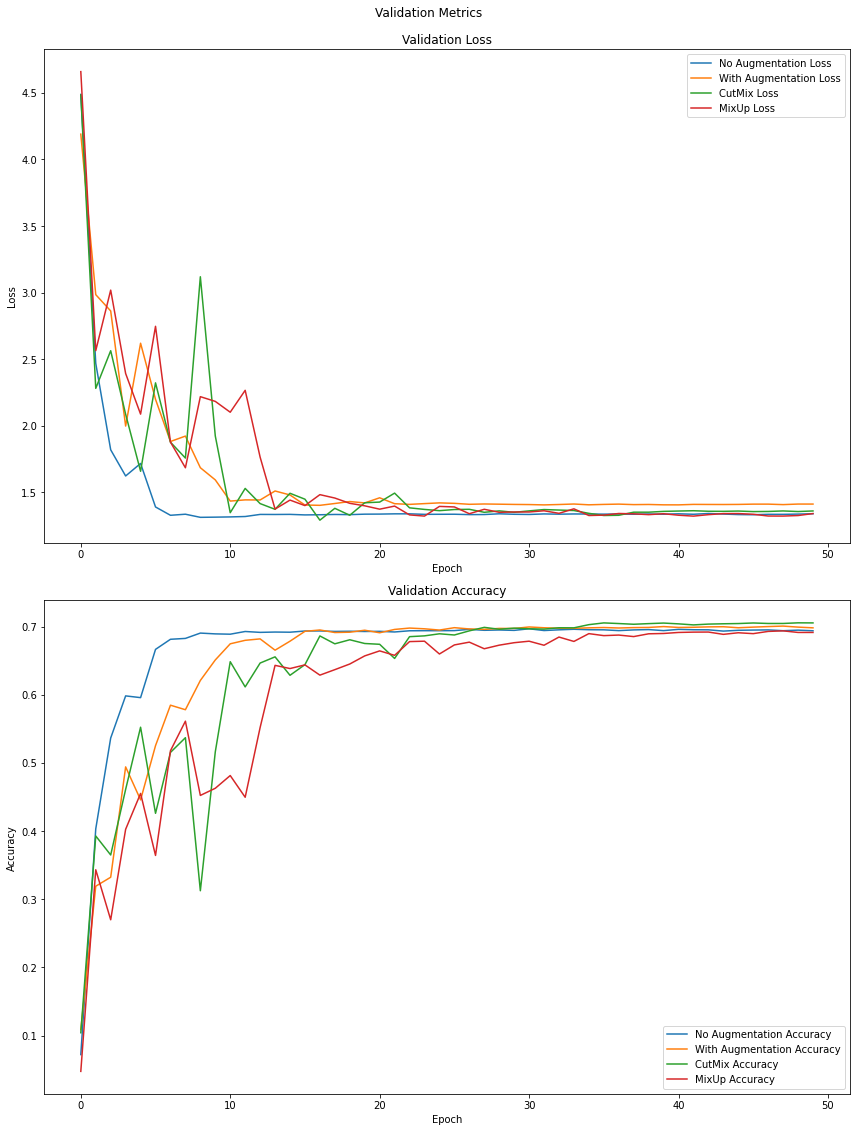
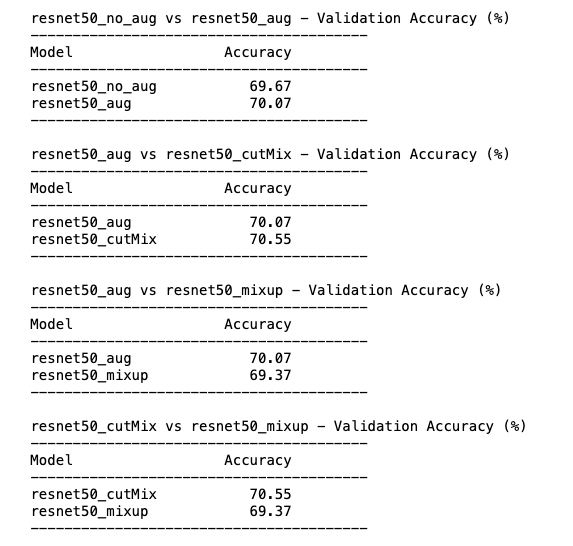

### 일곱번째 실험
- 전반적인 성능이 SGD 보다 안좋게 나왔음

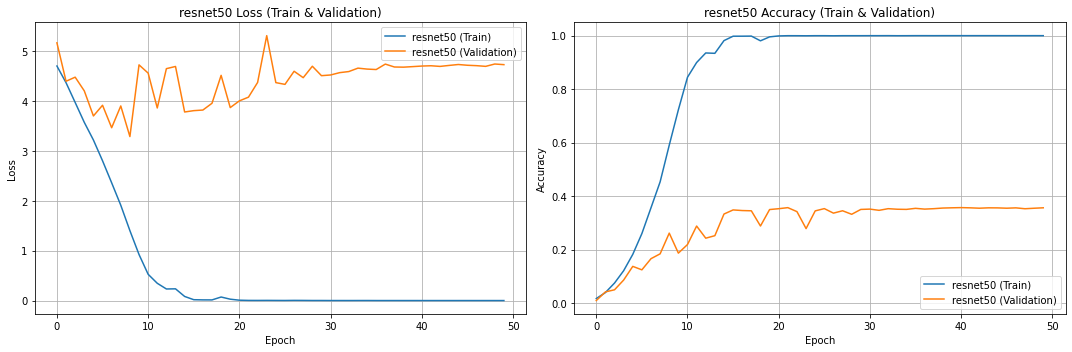
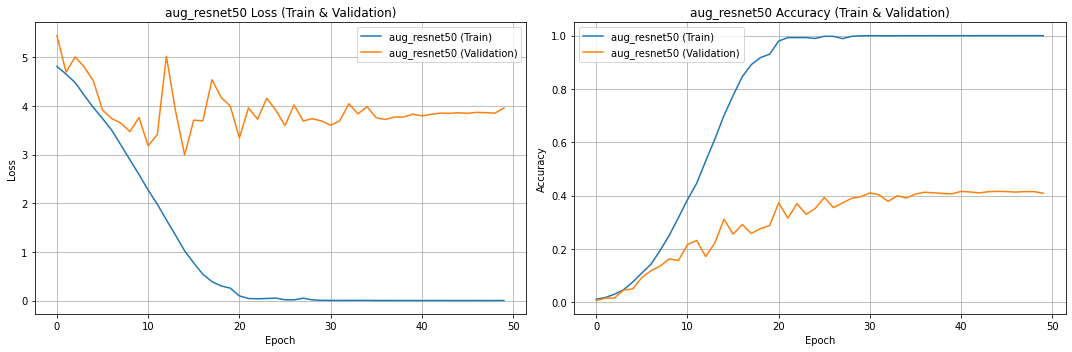
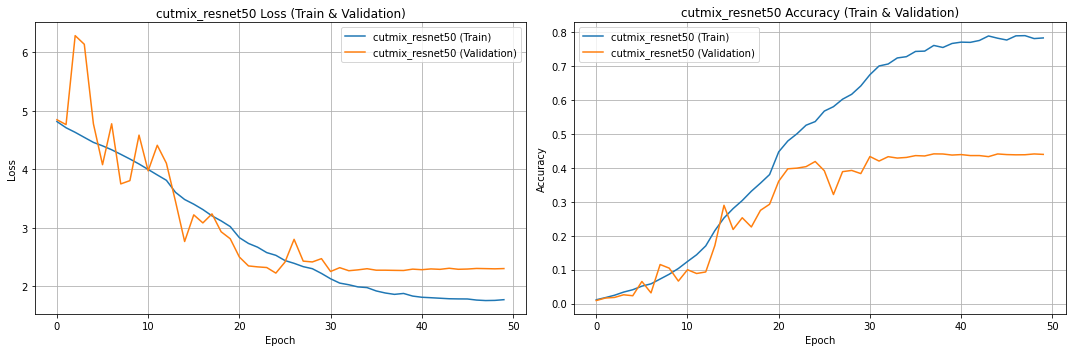
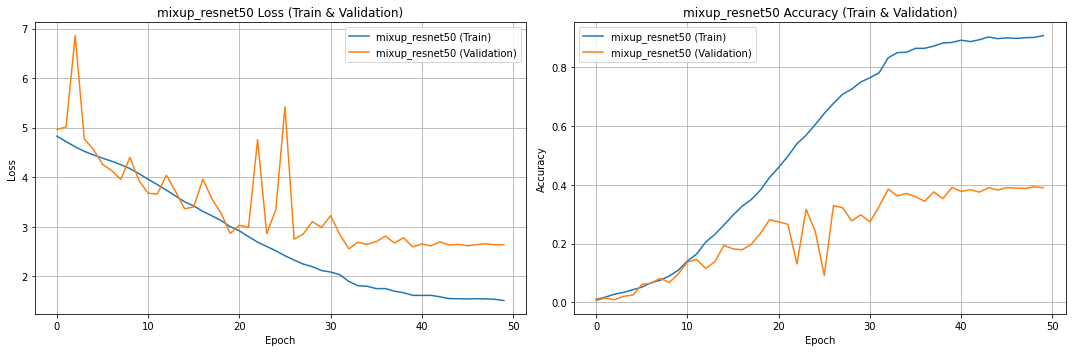
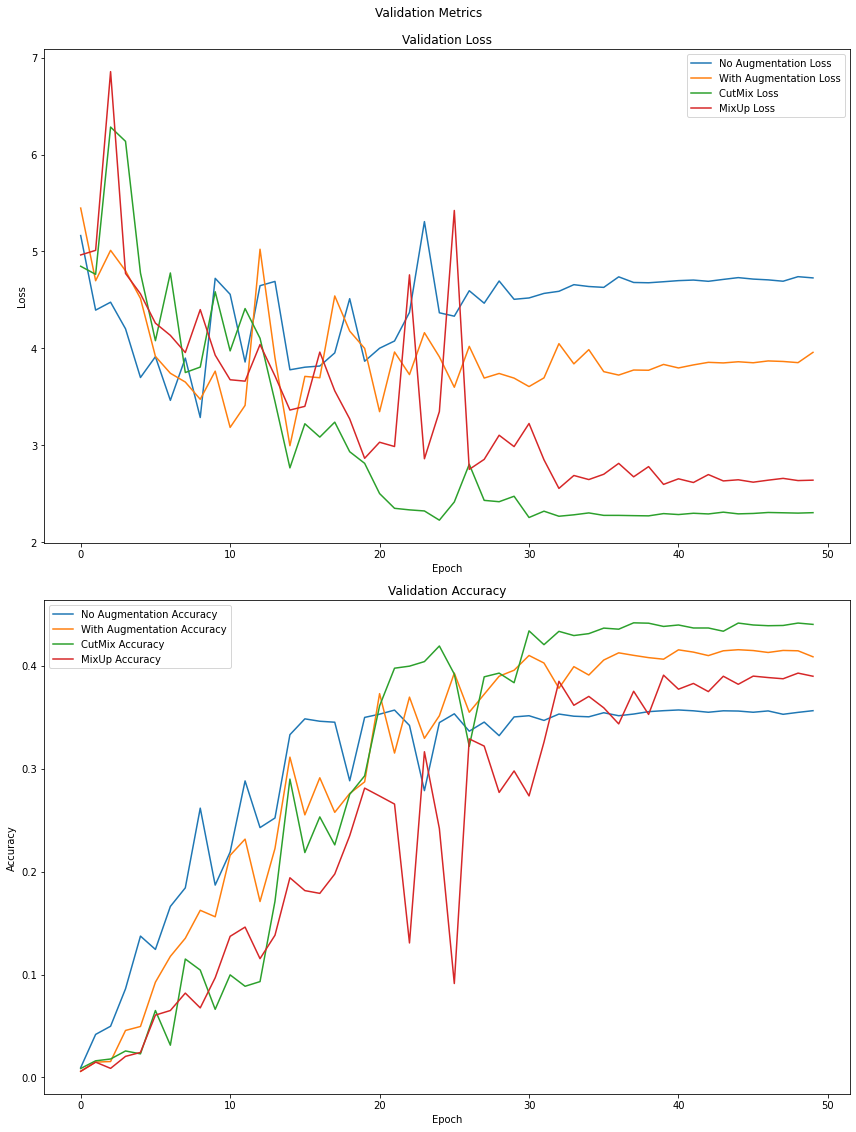
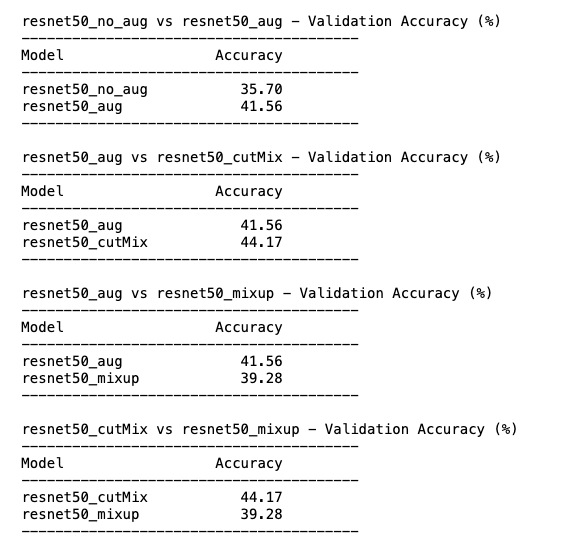

### 회고  

- accuracy 지표는 Cutmix 나 Mixup 이 오히려 낮게 나왔지만 일반화 성능이 낮다라고는 할 수 없을 거 같다.
- Cutmix 나 Mixup 의 학습 속도가 일반 augmentation 보다 훨씬 느린 경향을 보이기 때문에 충분한 학습 속도가 필요 할 것으로 보인다.
- Adam 보다 SGD 가 성능이 더 좋게 나왔다.
- optimizer 나 lr 에 따라 학습에서 차이를 보였다.


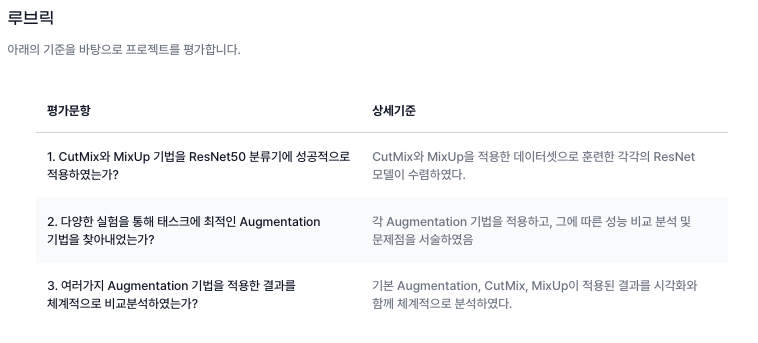